Naive variational message passing demo
===

ForneyLab comes with support for variational message passing (VMP). Variational methods often involve complicated and extensive derivations. VMP on a factor graph eases our derivation troubles by expressing the variational algorithm in terms of local update rules. In his 2007 article, Dauwels gives a generic introduction to VMP on a factor graph. ForneyLab implements this VMP approach.

In this demo we illustrate VMP by estimating the mean and variance of samples drawn from a Gaussian distribution. The factor graph below shows our generative model. We observe the samples $y = \{y_1, ..., y_k, ..., y_n\}$ and wish to estimate the posterior distribution over the mean and variance given these samples. We use the factor graph notation of (Reller, 2012; State-space methods in statistical signal processing) where filled black nodes represent observed variables and dotted arcs denote the repetition of a section.

<img src="images/gauss_est.png">

For estimation we use a variational message passing algorithm with a mean field factorized distribution over our variables $q(m,s,y) = q(m)\,q(s)\,q(y)$.

We start by building the graph.

In [1]:
using(ForneyLab)

# Initial settings
n_samples      = 20 # Number of observed samples
n_its          = 50 # Number of vmp iterations
true_mean      = 5.0
true_variance  = 2.0
y_observations = sqrt(true_variance)*randn(n_samples) + true_mean # y observation buffer

# Build graph
for sec=1:n_samples
    GaussianNode(id=s(:g,sec)) # s() for symbol concatenation
    EqualityNode(id=s(:m_eq,sec)) # Equality node chain for mean
    EqualityNode(id=s(:s_eq,sec)) # Equality node chain for variance
    TerminalNode(DeltaDistribution(y_observations[sec]), id=s(:y,sec)) # Observed y values are stored in terminal node values
    Edge(n(:g,sec).i[:out], n(:y,sec), GaussianDistribution)
    Edge(n(:m_eq,sec).i[3], n(:g,sec).i[:mean], GaussianDistribution)
    Edge(n(:s_eq,sec).i[3], n(:g,sec).i[:variance], InverseGammaDistribution)
    if sec > 1 # Connect sections
        Edge(n(:m_eq,sec-1).i[2], n(:m_eq,sec).i[1], GaussianDistribution)
        Edge(n(:s_eq,sec-1).i[2], n(:s_eq,sec).i[1], InverseGammaDistribution)
    end
end
# Attach beginning and end nodes
PriorNode(GaussianDistribution(m=0.0, V=100.0), id=:m0) # Prior
PriorNode(InverseGammaDistribution(a=0.01, b=0.01), id=:s0) # Prior
TerminalNode(vague(GaussianDistribution), id=:mN) # Uninformative distribution
TerminalNode(vague(InverseGammaDistribution), id=:sN) # Uninformative distribution
Edge(n(:m0), n(:m_eq1).i[1], GaussianDistribution)
Edge(n(:s0), n(:s_eq1).i[1], InverseGammaDistribution)
Edge(n(:m_eq,n_samples).i[2], n(:mN), GaussianDistribution)
Edge(n(:s_eq,n_samples).i[2], n(:sN), InverseGammaDistribution);

Next we need to specify the variational inference procedure. This sounds like a lot of work, but it can be accomlished automatically.

In [2]:
# Specify some write buffers
m_out = setWriteBuffer(n(:mN).i[:out].partner)
s_out = setWriteBuffer(n(:sN).i[:out].partner)

# Specify the variational algorithm for n_its vmp iterations
algo = VMP.Algorithm(n_iterations=n_its)

Algorithm with fields:
 q_distributions::Dict{(Node,Subgraph),QDistribution}
 factorization::QFactorization
 n_iterations::Int64

Use algorithm.fields[:field] to inspect field values.


Under the hood, the `VMP.Algorithm()` constructor performs a mean field factorization, generates a schedule towards wraps and write buffers, and initializes vague q-distributions.

We can visualize a subgraph of one factor with the `draw(::Subgraph)` function. The external edges of the subgraph are then denoted by red dashed arrows. 


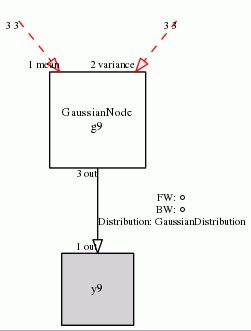

In [3]:
draw(algo.fields[:factorization].factors[3])

Now we can iteratively execute these schedules and inspect the results. 

In [4]:
step(algo)

# Inspect the results
println("True mean: $(true_mean)")
println("True variance: $(true_variance)")
println("Number of samples: $(length(y_observations))")
println("Sample mean: $(round(mean(y_observations),2))")
println("Sample variance: $(round(var(y_observations),2))")
println("\n----- Estimation after $(n_its) VMP updates -----")
println("Mean estimate: $(round(mean(m_out[end])[1],2)), with variance $(round(var(m_out[end])[1, 1],2))")
println("Variance estimate: $(round(mean(s_out[end]),2)), with variance $(round(var(s_out[end]),2))")

True mean: 5.0
True variance: 2.0
Number of samples: 20
Sample mean: 5.32
Sample variance: 1.67

----- Estimation after 50 VMP updates -----
Mean estimate: 5.32, with variance 0.03
Variance estimate: 1.8, with variance 0.4
